In [1]:
from datetime import datetime
import json
from typing import List

import pandas as pd

from IPython.display import display
import pyclip

import src.config as cfg
from  src.read_telega_dump import telega_dump_parse_essential
from src.data_classes import TelegaMessage
from src.telegram_messages_index import TelegaMessageIndex
from src.misc import visualize_topic_tree

#### Make import of telegram messages from some chat to json dump file and load dat from it here.  
Also need to load it to self made in-memory index

In [7]:
dump_path = cfg.messages_dump_path
msgs = telega_dump_parse_essential(dump_path=dump_path) # return iterator, not list
msgs_list = []
mi = TelegaMessageIndex()
for msg in msgs:
    mi.add_item(msg)
    msgs_list.append(msg)
# note: for data, taken from "export chat history", we do not have number of reactions 
len(msgs_list)



8746it [00:00, 88033.08it/s]


8746

#### Load this data to pandas df to have some statistics

In [6]:
dd = (msg.model_dump() for msg in msgs_list)
df = pd.DataFrame.from_dict(dd)
df.shape

(8746, 8)

In [26]:
# tz = timezone('Europe/Istanbul')
dt_range = (pd.Timestamp(year=2024, month=8, day=23), pd.Timestamp(datetime.now()))   # , tz=tm_zn        
number_of_days = (dt_range[1]-dt_range[0]).days
print(f'{number_of_days=}')
df = df[df.msg_date.between(*dt_range)]
df.shape

number_of_days=23


(3807, 8)

In [27]:
df['dummi'] = 1 # there should be less ugly way to get different aggegations without grouping
agg_df = df.groupby('dummi').aggregate({'msg_id':'count','msg_date':['min','max'], 'user_id': 'nunique'}).reset_index()
msgs_cnt = agg_df[( 'msg_id', 'count')][0]
min_date = agg_df[('msg_date', 'min')][0]
max_date = agg_df[('msg_date', 'max')][0]
number_of_days = (max_date-min_date).days
unique_users =  agg_df[('user_id', 'nunique')][0]
del df['dummi'] 
cols = ["Metric name", "Value"]
dt_format = "%Y-%m-%d"
d_report = [
    {cols[0]: "Number or messages", cols[1]: msgs_cnt},
    {cols[0]: "Date interval", cols[1]: f'from {min_date.strftime(dt_format)} to {max_date.strftime(dt_format)}' },
    {cols[0]: "Users count", cols[1]: unique_users },
    {cols[0]: "Avg messages per day", cols[1]: round(msgs_cnt/number_of_days , 1) },
    ]
pd.DataFrame.from_dict(d_report)

,Metric name,Value
0,Number or messages,3807
1,Date interval,from 2024-08-23 to 2024-09-13
2,Users count,142
3,Avg messages per day,181.3


#### playing around with data related to one, specific topic, given id of topic-staring messages

In [21]:


topic_msgs = mi.get_messages_tree(189845)
topic_msgs

[189845:2024-08-29 10:18:23; Ребят, кто кото-владельцы, а вы чем своих питомцев кормите?
 Мы покупали Farmina, сербского развеса, но на него ценник переписали - за месяц с 1100 до 1900 за полтора кг.
 Наш 2 пачки в месяц сжирает плюс паштетики еще, я прикинул - я за август на питание себя потратил наверно меньше,
 189875:2024-08-29 11:10:05; Сухой роял канин на развес по ~ 300 лир за кг,
 189916:2024-08-29 14:01:13; Фарминой кормим, кошка съедает 1,5 кг за 1,5 месяца. А что у вас за кот ( я как то удивлена 3 кг за 1 месяц…),
 189917:2024-08-29 14:01:46; Прожорливый,
 189918:2024-08-29 14:03:26; И какая именно фармина?,
 189919:2024-08-29 14:04:49; Может просто порода с весом около 6 кг и выше, тогда понятно,
 189920:2024-08-29 14:07:38; Кошки в принципе едят более адекватно. Все коты что у меня были не знают меры, и жрут как в последний раз,
 189922:2024-08-29 14:08:54; А коты были бывшие бездомными?,
 189923:2024-08-29 14:10:17; У меня обратная статистика 🙄,
 189924:2024-08-29 14:13:2

#### Visualize the  messages from topic tree

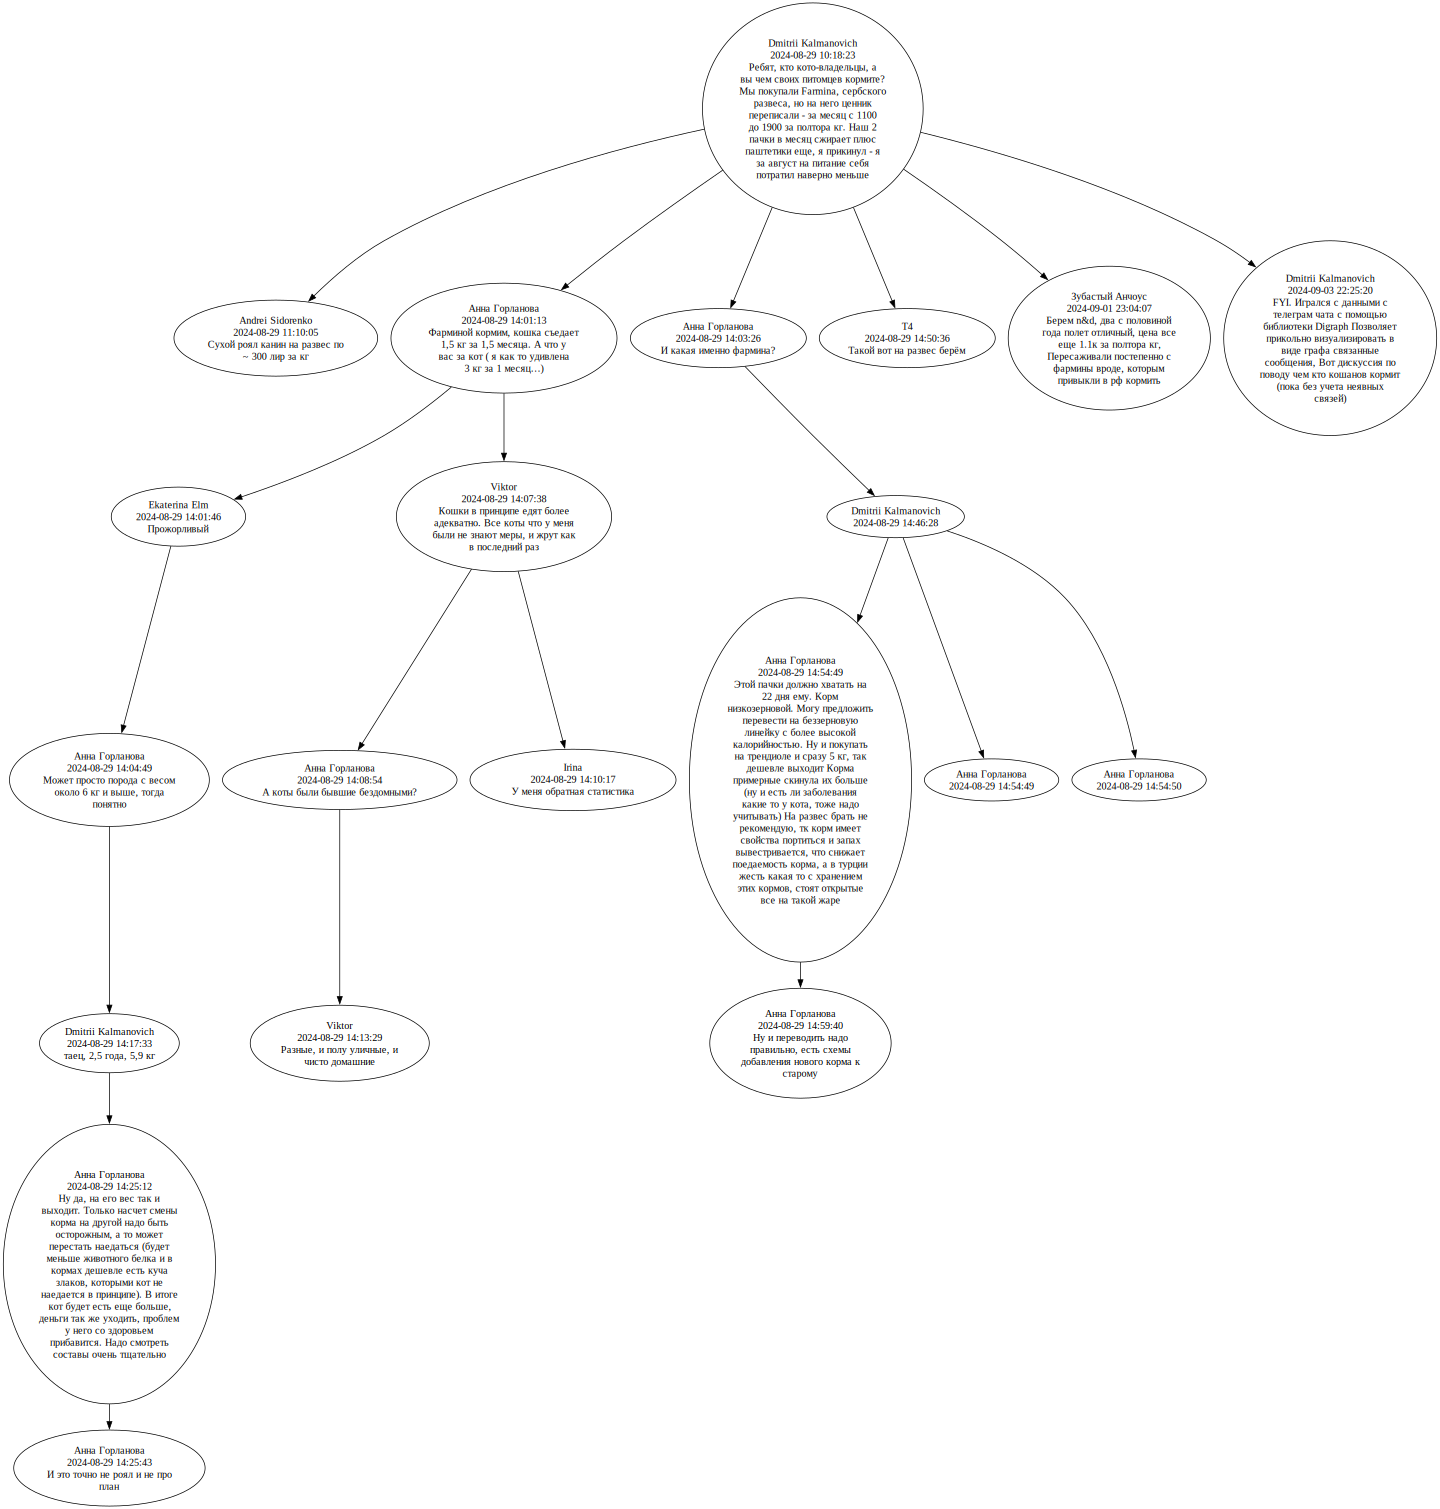

In [22]:

dot = visualize_topic_tree(topic_msgs)
dot.attr(size='20, 40')  # Width and height (in inches)
dot.attr(rankdir='TB')  # Top to bottom layout
dot.render('messages_tree', format='png', cleanup=True)  # save as PNG
display(dot)  # to display in Jupyter notebook


### Loading of data to elastic search index

In [3]:
from src.elastic_search import es
es.load_messages_from_dump()

8746it [00:00, 87893.23it/s]
100%|██████████| 8746/8746 [00:14<00:00, 585.16it/s]


#### Rag search using Elastic Search index


In [2]:
from src.elastic_search import es
search_field = 'msg_text'
tags = 'кот кормить'
srs = es.simple_search(search_term=tags, index_name=cfg.index_name_messages, search_field=search_field, min_score=4, size=30)
print(f'number of messages found {len(srs)}')
srs = [{**d, "score": score} for score, d in srs]
srs.sort(key= lambda x: x['msg_id'])
df = pd.DataFrame.from_dict(srs)
df


/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of messages found 30


,msg_date,reply_to_msg_id,msg_text,msg_id,chat_id,score
0,2024-08-06T22:50:58,NaN,Глориа-джинсовый кот,184792,1688539638,7.782904
1,2024-08-17T23:59:33,NaN,"Тырят кошачий корм, но возможно это и есть кот...",187615,1688539638,10.555922
2,2024-08-18T00:00:17,187615.0,Да у нас внизу у соседей коты и на балконе в г...,187616,1688539638,5.396717
3,2024-08-18T00:09:35,NaN,"Подумал, лишь бы они от изобилия корма не эвол...",187620,1688539638,4.968675
4,2024-08-18T00:10:16,187620.0,От изобилия корма не эволюционируют) а как раз...,187621,1688539638,7.197836
5,2024-08-23T18:38:43,177570.0,кто пользовался ? а то мне тут за уличного кот...,188611,1688539638,6.543031
6,2024-08-25T00:15:42,188764.0,"У меня кот кошачий паштет разлюбил, открыл бан...",188809,1688539638,4.769958
7,2024-08-25T00:17:41,188809.0,"Подождите до завтра, не спешите.\nКот сходит в...",188810,1688539638,5.643915
8,2024-08-25T22:29:51,NaN,если вдруг кто знает кота Степана и может подс...,188894,1688539638,4.962050
9,2024-08-29T10:18:23,NaN,"Ребят, кто кото-владельцы, а вы чем своих пито...",189845,1688539638,5.873332


In [12]:
import json
def jsonsify(inp: str):
    inp = inp.replace('```json', '').replace('```','')
    parsed_json = json.loads(inp)
    pretty_json = json.dumps(parsed_json, indent=4, ensure_ascii=False)
    return pretty_json

In [ ]:
from  src.rag_integration import RaguDuDu
question = 'I have a Thai cat. How should I feed him?'
rg = RaguDuDu()
ret = rg.rag_by_messages(question=question, tags=tags)


In [13]:

pretty_json = jsonsify(ret)
print(pretty_json)

{
    "answer": "To feed your Thai cat properly, it's recommended to provide a balanced diet that includes both dry and wet food. Regular dry food should be available in free access, but it's also important to add wet food a few times a week to ensure proper hydration and nutrition. It's crucial to avoid overfeeding and to adjust portions according to your cat's weight and health. Additionally, monitor the quality of the food you choose, as some brands may contain too many fillers and not enough protein.",
    "msg_ids": [
        189880,
        189881,
        189882,
        189883,
        190367
    ]
}


### vector based RAG search using index over topics
1) are taking some message, that might be any message in the topic, fetching the messages, that could potentially constitue a topic.
2) we are feeding these messages to LLM to extract topic and give relevant messages. 
    LLM should also provide some pairs of questions and answers, related to this topic.
    These pairs supposed to be used later for evaluation (not implemented yet)
3) we are pushing this "topic" document into Elastic Search as a new document


In [10]:
rag_ret = rg.get_topic_summary_by_message(topic_message_id=189845)
rag_ret = rag_ret.replace('```json', '').replace('```','')
topic_doc = json.loads(rag_ret)
pretty_json = json.dumps(topic_doc, indent=4,  ensure_ascii=False)
print(pretty_json)


{
    "topic_name": "Питание домашних животных",
    "topic_name_eng": "Feeding Pets",
    "topic_summary": "В обсуждении рассматриваются различные корма для котов, их стоимость и диета. Участники делятся опытом и рекомендациями по нормированию питания, а также обсуждают производители корма и особенности кормления стерилизованных котов.",
    "topic_summary_eng": "The discussion focuses on different cat food brands, their cost, and diet. Participants share experiences and recommendations regarding portion control, and also discuss the food producers and feeding sterilized cats.",
    "topic_tags": [
        "корм",
        "кошки",
        "питомцы",
        "диета",
        "питание"
    ],
    "topic_tags_eng": [
        "food",
        "cats",
        "pets",
        "diet",
        "feeding"
    ],
    "msg_ids": [
        189845,
        189875,
        189876,
        189877,
        189878,
        189916,
        189917,
        189918,
        189919,
        189920,
        1

In [11]:

es.index_docs(docs=[topic_doc], index_name=cfg.index_name_topics, recreate_index=False)
# pushing document with a new topic into ES index

/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flip

#### we are using the ES index with topics for verctor based RAG search.
As I didn't find reliable way to leverage Sentense tranformer models to work with russian text, we are making vector search across english translations of topic summary


In [ ]:
question = 'I have a Thai cat. How should I feed him? '
ret = rg.rag_by_topics(question=question)


In [ ]:
import json
ret = ret.replace('```json', '').replace('```','')
parsed_json = json.loads(ret)
pretty_json = json.dumps(parsed_json, indent=4, ensure_ascii=False)
print(pretty_json)

translation of telegram messages with chunking and overlapping 


In [2]:
from src.rag_integration import translate_messages
import src.llm as llm
out_dir = 'output/llm_output'

dump_path = cfg.messages_dump_path
msgs = telega_dump_parse_essential(dump_path=dump_path) # return iterator, not list
msgs_to_translate = (msg for msg in msgs if msg.msg_id > 189785)
max_tokens_count = 8000 * 1.5
# gpt-4o mini; mulitpying to approx coef to be sure we can fit to context window and does not exeed number of max output tokens  
translate_messages(msgs_to_translate, out_dir, max_tokens_count=max_tokens_count, overlapping_msgs_cnt=2)
print(f'amount_spend total:{llm.TOTAL_SPEND:.5f} USD')

/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]

chunk is ready for 133 msgs: 189786-189919, chunk_symbols_count=23859


6266it [01:12, 86.33it/s]

amount_spend total:0.00504, last: 0.00504 USD
data written to output/llm_output/messages189786-189919.json
chunk is ready for 137 msgs: 189918-190056, chunk_symbols_count=23944


6401it [02:32, 34.61it/s]

amount_spend total:0.00998, last: 0.00494 USD
data written to output/llm_output/messages189918-190056.json
chunk is ready for 147 msgs: 190055-190203, chunk_symbols_count=23991


6546it [03:48, 19.79it/s]

amount_spend total:0.01489, last: 0.00491 USD
data written to output/llm_output/messages190055-190203.json
chunk is ready for 134 msgs: 190202-190337, chunk_symbols_count=23908


6678it [05:01, 12.84it/s]

amount_spend total:0.01966, last: 0.00477 USD
data written to output/llm_output/messages190202-190337.json
chunk is ready for 129 msgs: 190336-190466, chunk_symbols_count=23791


6805it [06:31,  8.23it/s]

amount_spend total:0.02440, last: 0.00473 USD
data written to output/llm_output/messages190336-190466.json
chunk is ready for 147 msgs: 190465-190612, chunk_symbols_count=23946


6950it [07:49,  6.13it/s]

amount_spend total:0.02936, last: 0.00496 USD
data written to output/llm_output/messages190465-190612.json
chunk is ready for 184 msgs: 190611-190797, chunk_symbols_count=23943


7132it [09:02,  5.00it/s]

amount_spend total:0.03447, last: 0.00511 USD
data written to output/llm_output/messages190611-190797.json
chunk is ready for 175 msgs: 190796-190970, chunk_symbols_count=23920


7305it [11:20,  3.30it/s]

amount_spend total:0.04022, last: 0.00576 USD
data written to output/llm_output/messages190796-190970.json
chunk is ready for 130 msgs: 190969-191101, chunk_symbols_count=23953


7433it [12:33,  2.91it/s]

amount_spend total:0.04507, last: 0.00484 USD
data written to output/llm_output/messages190969-191101.json
chunk is ready for 146 msgs: 191100-191245, chunk_symbols_count=23863


7577it [14:22,  2.35it/s]

amount_spend total:0.05071, last: 0.00564 USD
data written to output/llm_output/messages191100-191245.json
chunk is ready for 149 msgs: 191244-191392, chunk_symbols_count=23549


7724it [15:33,  2.28it/s]

amount_spend total:0.05570, last: 0.00499 USD
data written to output/llm_output/messages191244-191392.json
chunk is ready for 136 msgs: 191391-191530, chunk_symbols_count=23928


7858it [16:52,  2.11it/s]

amount_spend total:0.06087, last: 0.00516 USD
data written to output/llm_output/messages191391-191530.json
chunk is ready for 162 msgs: 191529-191695, chunk_symbols_count=23943


8018it [18:43,  1.87it/s]

amount_spend total:0.06608, last: 0.00521 USD
data written to output/llm_output/messages191529-191695.json
chunk is ready for 143 msgs: 191694-191837, chunk_symbols_count=23995


8159it [19:42,  1.98it/s]

amount_spend total:0.07055, last: 0.00447 USD
data written to output/llm_output/messages191694-191837.json
chunk is ready for 154 msgs: 191836-191994, chunk_symbols_count=23928


8311it [21:00,  1.97it/s]

amount_spend total:0.07558, last: 0.00503 USD
data written to output/llm_output/messages191836-191994.json
chunk is ready for 147 msgs: 191993-192140, chunk_symbols_count=23202


8456it [22:11,  2.00it/s]

amount_spend total:0.08032, last: 0.00474 USD
data written to output/llm_output/messages191993-192140.json
chunk is ready for 150 msgs: 192139-192288, chunk_symbols_count=23956


8746it [23:22,  6.24it/s]

amount_spend total:0.08542, last: 0.00510 USD
data written to output/llm_output/messages192139-192288.json
chunk is ready for 145 msgs: 192287-192434, chunk_symbols_count=21836


amount_spend total:0.09001, last: 0.00459 USD
data written to output/llm_output/messages192287-192434.json
amount_spend total:0.09001 USD


After we have prepared files with translated chunks of messages, need to merge in, considering overlapping sets

In [23]:
import os
import json
import glob
import re

from tqdm import tqdm

merged_data = []
search_folder = 'output/llm_output'

dump_path = cfg.messages_dump_path
msgs = telega_dump_parse_essential(dump_path=dump_path) # return iterator, not list
msgs_d = {x.msg_id: x for x in msgs}
msg_ids = set()

def clean_json_str(json_str: str):
    json_str = re.sub('"reply_to_msg_id":\s?\d+', '', json_str)    
    # Remove trailing commas before closing brackets       
    json_str = re.sub(r',\s*([\]}])', r'\1', json_str)  

for filename in glob.glob(os.path.join(search_folder, 'messages*.json')):
    print(f'parsing file name {filename}')
    with open(filename, 'r', encoding='utf-8') as file:
        json_str = file.read()

        json_str = clean_json_str(json_str)
        data = json.loads(json_str)
        #data = json.load(file)
        cnt = 0
        for tr_msg in tqdm(data): #  translated messages
            cnt += 1
            msg_id = tr_msg['msg_id']
            if msg_id in msg_ids: # we did ovelapping chuks of messages
                break
            msg_ids.add(msg_id)
            same_msg = msgs_d.get(msg_id)
            if not same_msg:
                print(f'msg_id {msg_id} not found in dump, something is wrong')
                continue
            if same_msg.reply_to_msg_id:
                tr_msg['reply_to_msg_id'] = same_msg.reply_to_msg_id
            tr_msg['user_id'] = same_msg.user_id
            merged_data.append(tr_msg)
            

with open(f'{search_folder}/merged_messages.json', 'w') as outfile:
    json.dump(merged_data, outfile)



8746it [00:00, 30061.08it/s]


parsing file name output/llm_output/messages186484-186615.json


100%|██████████| 130/130 [00:00<00:00, 746930.85it/s]


parsing file name output/llm_output/messages192139-192288.json


100%|██████████| 150/150 [00:00<00:00, 986121.63it/s]


parsing file name output/llm_output/messages184008-184153.json


100%|██████████| 142/142 [00:00<00:00, 807034.10it/s]


parsing file name output/llm_output/messages185538-185685.json


100%|██████████| 145/145 [00:00<00:00, 793960.94it/s]


parsing file name output/llm_output/messages190796-190970.json


100%|██████████| 175/175 [00:00<00:00, 916358.55it/s]


parsing file name output/llm_output/messages185987-186106.json


100%|██████████| 65/65 [00:00<00:00, 448404.21it/s]


parsing file name output/llm_output/messages184932-185079.json


100%|██████████| 146/146 [00:00<00:00, 777117.24it/s]


parsing file name output/llm_output/messages186614-186777.json


  0%|          | 0/163 [00:00<?, ?it/s]


parsing file name output/llm_output/messages184426-184574.json


100%|██████████| 142/142 [00:00<00:00, 723683.07it/s]


parsing file name output/llm_output/messages191100-191245.json


100%|██████████| 146/146 [00:00<00:00, 651455.73it/s]


parsing file name output/llm_output/messages187238-187348.json


100%|██████████| 111/111 [00:00<00:00, 680654.60it/s]


parsing file name output/llm_output/messages191529-191695.json


100%|██████████| 162/162 [00:00<00:00, 798445.65it/s]


parsing file name output/llm_output/messages187499-187650.json


100%|██████████| 152/152 [00:00<00:00, 731117.21it/s]


parsing file name output/llm_output/messages191993-192140.json


 99%|█████████▊| 145/147 [00:00<00:00, 788812.04it/s]


parsing file name output/llm_output/messages190611-190797.json


 99%|█████████▉| 182/184 [00:00<00:00, 933207.00it/s]


parsing file name output/llm_output/messages191244-191392.json


  0%|          | 0/149 [00:00<?, ?it/s]


parsing file name output/llm_output/messages183554-183706.json


100%|██████████| 145/145 [00:00<00:00, 503455.36it/s]


parsing file name output/llm_output/messages185378-185539.json


 99%|█████████▊| 146/148 [00:00<00:00, 764504.85it/s]


parsing file name output/llm_output/messages186217-186360.json


100%|██████████| 144/144 [00:00<00:00, 799973.21it/s]


parsing file name output/llm_output/messages190055-190203.json


100%|██████████| 147/147 [00:00<00:00, 777506.54it/s]


parsing file name output/llm_output/messages186776-186931.json


100%|██████████| 155/155 [00:00<00:00, 838860.80it/s]


parsing file name output/llm_output/messages187347-187500.json


  0%|          | 0/152 [00:00<?, ?it/s]


parsing file name output/llm_output/messages192287-192434.json


  0%|          | 0/145 [00:00<?, ?it/s]


parsing file name output/llm_output/messages187649-187808.json


  0%|          | 0/160 [00:00<?, ?it/s]


parsing file name output/llm_output/messages183705-183836.json


  0%|          | 0/132 [00:00<?, ?it/s]


parsing file name output/llm_output/messages188855-188980.json


100%|██████████| 124/124 [00:00<00:00, 771652.37it/s]


parsing file name output/llm_output/messages183835-184009.json


 99%|█████████▉| 170/172 [00:00<00:00, 794907.11it/s]


parsing file name output/llm_output/messages184294-184427.json


 98%|█████████▊| 127/129 [00:00<00:00, 132145.03it/s]


parsing file name output/llm_output/messages189251-189393.json


100%|██████████| 142/142 [00:00<00:00, 747291.30it/s]


parsing file name output/llm_output/messages187963-188119.json


100%|██████████| 153/153 [00:00<00:00, 792257.42it/s]


parsing file name output/llm_output/messages189516-189652.json


100%|██████████| 136/136 [00:00<00:00, 866907.82it/s]


parsing file name output/llm_output/messages184152-184295.json


  0%|          | 0/144 [00:00<?, ?it/s]


parsing file name output/llm_output/messages189115-189252.json


 99%|█████████▊| 135/137 [00:00<00:00, 813550.34it/s]


parsing file name output/llm_output/messages185224-185379.json


 99%|█████████▊| 154/156 [00:00<00:00, 827045.86it/s]


parsing file name output/llm_output/messages186359-186485.json


  0%|          | 0/115 [00:00<?, ?it/s]


parsing file name output/llm_output/messages187077-187239.json


 99%|█████████▊| 157/159 [00:00<00:00, 826230.52it/s]


parsing file name output/llm_output/messages186105-186218.json


 98%|█████████▊| 112/114 [00:00<00:00, 818400.78it/s]


parsing file name output/llm_output/messages191836-191994.json


 99%|█████████▊| 152/154 [00:00<00:00, 523857.20it/s]


parsing file name output/llm_output/messages190465-190612.json


 99%|█████████▊| 145/147 [00:00<00:00, 249968.80it/s]


parsing file name output/llm_output/messages185078-185225.json


  0%|          | 0/143 [00:00<?, ?it/s]


parsing file name output/llm_output/messages188712-188856.json


 99%|█████████▊| 142/144 [00:00<00:00, 850844.53it/s]


parsing file name output/llm_output/messages189392-189517.json


  0%|          | 0/126 [00:00<?, ?it/s]


parsing file name output/llm_output/messages184776-184933.json


JSONDecodeError: Expecting ',' delimiter: line 523 column 9 (char 19880)